**"Safety belt" type integration (LLM as a black box)**
--


**Escenario: API LLM + Cinturón de seguridad**

**Contexto funcional**: un usuario realiza un request (texto libre) y llama a un LLM (por API) para generar respuestas.

**Riesgo**: un atacante (o un intermediario - adversario en el medio) modifica el input (prompt injection, cambios semánticos, inserción de instrucciones ocultas) para forzar al LLm a violar políticas o filtrar información.  

**Objetivo del mechanismo**: garantizar que el texto enviado al LLM:
1. Proviene del cliente autorizado (autenticidad),
2. No fue modificado en tránsito o por un plugin (integridad),
3. Cumple un *policy gate* preventivo (bloqueo/mitigación)


**Arquitectura mínima**
---

**1) Client**
- Genera: user_text, session_id, timestamp, nonce, context_id
- Envía a tu servidor por HTTPS.

**2) WatermarkEncoder (*Watermark Generator*)**
- Construye un payload canónico (normalización) y produce un tag verificable.
- Generator(canonical_payload) + metadatos.

**Salida:**
- marked_request = {payload, tag, meta}

**3) BeltVerifier (cinturón antes del LLM)**
- Recalcula el tag esperado y compara.
- Emite un estado: VALID, SUSPECT, INVALID
- Aplica una política de decisión (gating):
  - VALID → pasa al LLM
  - SUSPECT → reescritura defensiva o modo seguro
  - INVALID → bloqueo + solicitud de re-emisión

**4) LLMAdapter (API wrapper)**
- Es el único que tiene permisos para llamar a la API del LLM.
- Recibe solo texto ya aprobado.

**5) AuditLogger**
- Registra: hash del input canónico, resultado del verificador, decisión, latencia, respuesta.



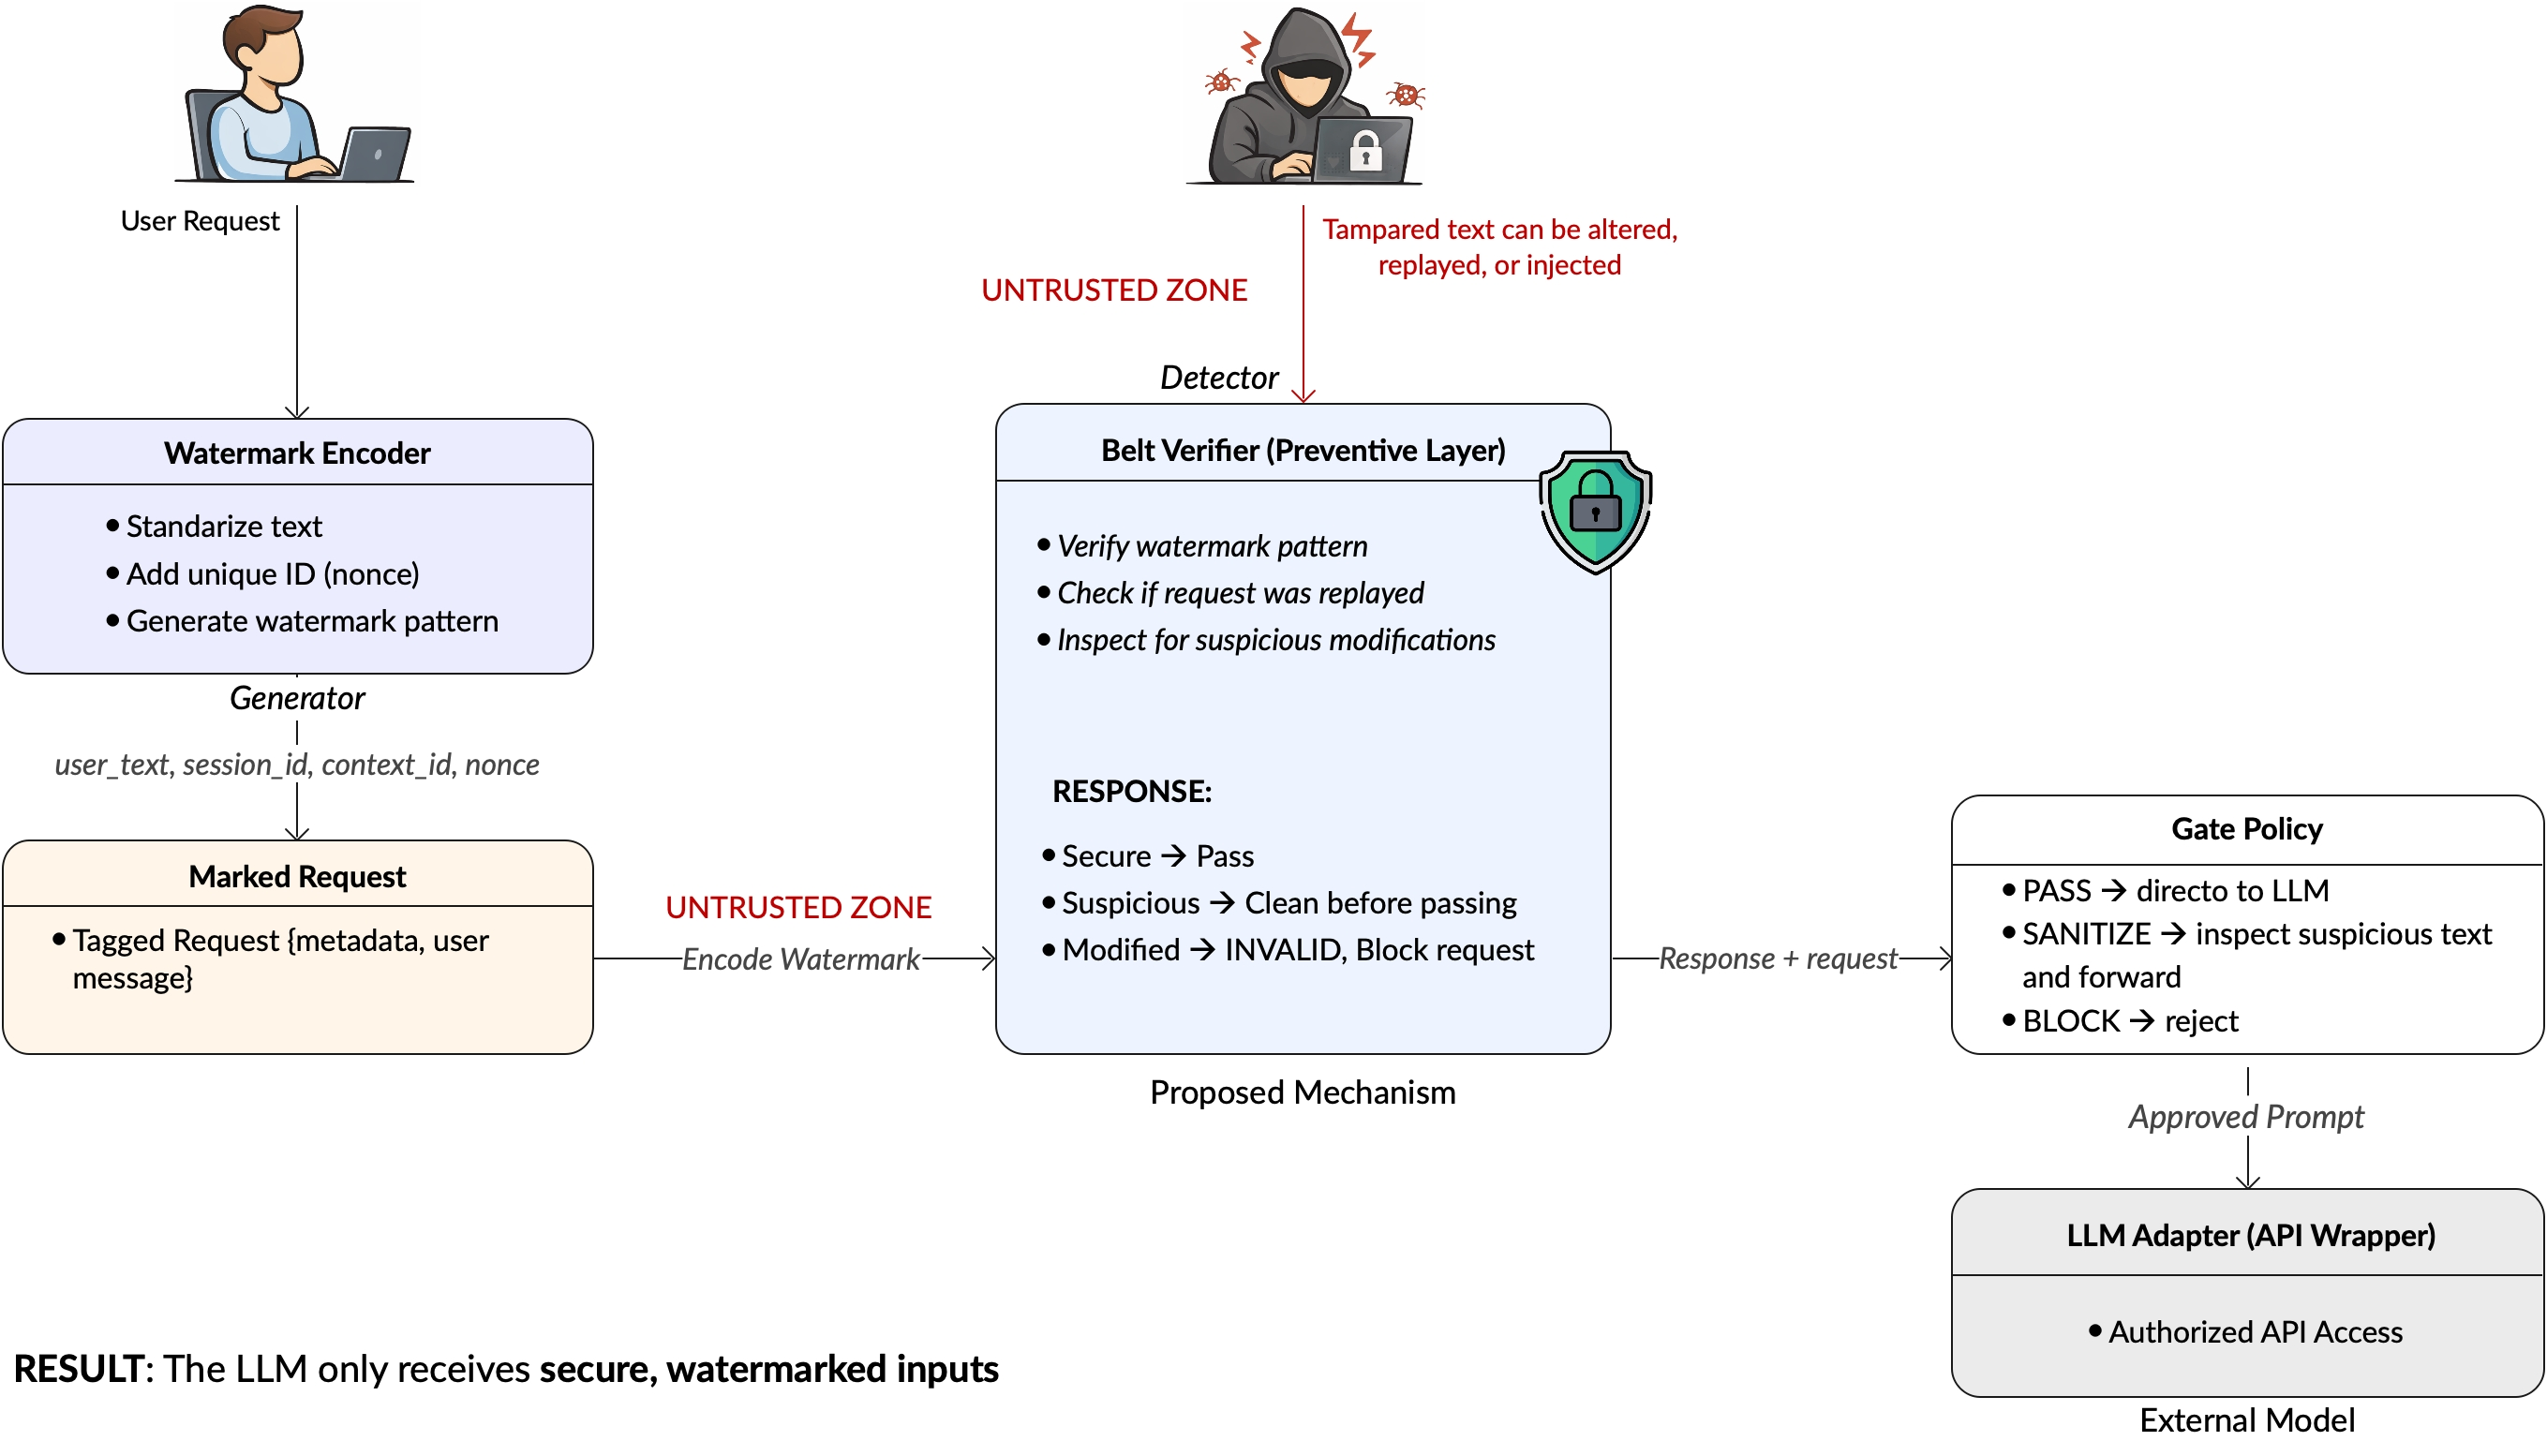

In [ ]:
pip install Crypto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding: utf-8 -*-
# ===========================
# Watermark "Belt" + LLM API Simulation (Demo Module)
# ===========================
"""
  Watermarked Request Pipeline (demo):

    - Encoder:
        Inserts a textual watermark into user requests using invisible characters.

    - MarkedRequest:
        Wraps the watermarked payload with metadata (timestamp, nonce, session, etc.).

    - BeltVerifier:
        Verifies watermark consistency before granting access to the LLM.

    - LLMAdapter:
        Wraps an LLM client (real or simulated) and measures latency.

    - WatermarkedLLMPipeline:
        Orchestrates the end-to-end flow:
          user → encoder → belt verifier → LLM → response.
"""

**Imports & Configuration**
---



In [ ]:
# ===========================
# Imports & Configuration
# ===========================
import time
import random
import string
import hashlib
from functools import reduce
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Protocol, Tuple

# Example path to the training dataset used to derive the secret key.
# Replace this path with the actual location of your corpus.
DEFAULT_DATASET_PATH = (
    "/content/drive/corpus.gold"
)

# Invisible character used as a watermark marker (imperceptible whitespace).
INVISIBLE_MARK = "\u180e"


In [ ]:
def canonicalize_text(user_text: str, normalize_whitespace: bool = True, normalize_newlines: bool = True, unicode_nfkc: bool = True) -> str:
  """
  Canonicalizes user_text to make the signature more stable under benign perturbations.

  Parameters
  ----------
  user_text : str
      Raw input text.
  normalize_whitespace : bool
      If True, collapses multiple whitespace characters into a single space.
  normalize_newlines : bool
      If True, normalizes CRLF/CR to LF and removes newlines.
  unicode_nfkc : bool
      If True, applies Unicode NFKC normalization and basic cleaning.

  Returns
  -------
  str
      Canonicalized text.
  """
  if normalize_newlines:
    user_text = user_text.replace("\r\n", "\n").replace("\r", "\n")
    # In this setting we remove explicit newlines to get a single-line representation
    user_text = user_text.replace("\n", "")
    user_text = user_text.strip()

  if unicode_nfkc:
    import unicodedata

    # Lowercasing and basic symbol cleanup
    user_text = (
        user_text.lower()
        .replace("…", " ")
        .replace("$t$", "")
        .replace("//", " ")
        .replace("l'o", "o")
        .replace("(…)", " ")
        .replace("d´", "d")
    )

    # Replace double spaces
    user_text = user_text.replace("  ", " ")

    # Remove a set of special characters
    special_character = ',!:()."?¡¿″;-/<+>”““”"’º‘[]%áéíóú*“”″”º%$€'
    user_text = unicodedata.normalize("NFKC", user_text)
    table = str.maketrans("", "", special_character)
    user_text = user_text.translate(table)

  if normalize_whitespace:
    import re

    # Collapse any remaining repeated whitespace to a single space
    user_text = re.sub(r"\s+", " ", user_text).strip()

  return user_text


def now_unix() -> int:
  """Returns the current Unix timestamp (seconds since epoch)."""
  return int(time.time())


def gen_nonce(n: int = 16) -> str:
  """Generates a random alphanumeric nonce of length n."""
  alphabet = string.ascii_letters + string.digits
  return "".join(random.choice(alphabet) for _ in range(n))


# ============================
# Data model
# ============================
class MarkedRequest:
  """
  Represents a watermarked user request enriched with metadata.
  """

  def __init__(self, user_request: str, latency_ms: float, session: int):
    self.user_request: str = user_request   # already watermarked payload
    self.nonce: str = gen_nonce(16)
    self.latency_ms: float = latency_ms
    self.session: int = session
    self.timestamp: int = now_unix()
    self.context: Dict[str, Any] = {}

    # Initialize default context metadata
    self._initialize_context()

  def _initialize_context(self) -> None:
    """Initializes the context used for watermark-related reasoning."""
    self.context["canonical"] = "meta+payload"
    self.context["encoding"] = "UTF-8"
    self.context["transport"] = "text/plain"


@dataclass
class VerificationResult:
  """
  Structured result of the watermark verification step.
  """
  status: str            # VALID | SUSPECT | INVALID
  reason: str
  latency_ms: float
  meta_request: MarkedRequest

**Encoder**
--

In [ ]:
# ============================
# Watermark Encoder (mechanism)
# ============================
class Encoder:
  """
  Watermark mechanism:

  - Derives a secret key and maximum sentence length from a reference corpus.
  - Embeds a watermark into the user request using invisible characters.
  - Produces a MarkedRequest instance.
  """

  DATASET_PATH = DEFAULT_DATASET_PATH
  INVISIBLE_MARK = INVISIBLE_MARK

  def __init__(self, user_request: str, session_id: int = 0):
    self.user_request: str = user_request
    self.session_id: int = session_id
    self.secret_key: Optional[str] = None
    self.max_sentence_length: int = 0
    self.meta_request: Optional[MarkedRequest] = None

    self._set_secret_key()
    self._encode_request()

  # ------------------------------------------------------
  # Secret key and sentence-length derivation from dataset
  # ------------------------------------------------------
  def _set_secret_key(self) -> None:
    """
    Generates the secret key and the maximum sentence length from the dataset.

    The secret key acts as a hidden parameter of the watermark mechanism.
    The maximum sentence length bounds the instance-level hash-table size.
    """
    path = self.DATASET_PATH

    with open(path, "r", encoding="utf-8") as doc_train:
        data_train = [
            line.replace("\n", "").replace("  ", " ").lower()
            for line in doc_train
        ]

    concatenated_text = reduce(
        lambda x, y: x + " " + canonicalize_text(y),
        data_train
    )

    hash_data = hashlib.shake_256()
    hash_data.update(concatenated_text.encode("utf-8"))

    # 64 hex characters from SHAKE-256 as secret key
    self.secret_key = hash_data.hexdigest(64)

    # Maximum sentence length in tokens
    self.max_sentence_length = max(len(sentence.split()) for sentence in data_train)

  # ------------------------------------------------------
  # Term-level encoding primitive
  # ------------------------------------------------------
  def _encode_term(self, term: str, m_term: int) -> str:
    """
      Encodes a single term using a hash-table-based character placement strategy.

      Slots in the hash table that do not receive characters are filled
      with invisible markers.
    """
    if m_term <= 0:
        return term

    term_hash_table: List[Optional[int]] = [None for _ in range(m_term)]

    index = 0
    for char in term:
      index += 1
      slot = (ord(char) + index) % m_term

      if term_hash_table[slot] is None:
          term_hash_table[slot] = 1
      else:
          # Linear probing to resolve collisions
          for i in range(len(term_hash_table)):
              if term_hash_table[i] is None:
                  term_hash_table[i] = 1
                  break

    encoded_term: List[str] = []
    char_index = -1

    for slot in term_hash_table:
      if slot is None:
          encoded_term.append(self.INVISIBLE_MARK)
      else:
          char_index += 1
          if char_index < len(term):
              encoded_term.append(term[char_index])
          else:
              encoded_term.append(self.INVISIBLE_MARK)

    return "".join(encoded_term)

  # ------------------------------------------------------
  # Request-level encoding
  # ------------------------------------------------------
  def _encode_request(self) -> None:
    """
    Encodes self.user_request using an instance-level hash table and
    term-level encoding.

    Side effects:
    - Overwrites self.user_request with its watermarked representation.
    - Creates self.meta_request (MarkedRequest).
    """
    if not self.secret_key:
      raise ValueError("secret_key must be initialized before calling _encode_request().")

    start_time = time.time()

    # 1) Hash-table size for the instance
    secret_sum = sum(ord(c) for c in self.secret_key)
    m_instances = self.max_sentence_length if secret_sum % self.max_sentence_length < self.max_sentence_length else secret_sum % self.max_sentence_length


    # secret_sum % self.max_sentence_length or self.max_sentence_length

    instance_hash_table: List[Optional[int]] = [None for _ in range(m_instances)]

    terms = self.user_request.split()

    # 2) Determine which slots will contain terms
    index = 0
    for term in terms:
      index += 1
      slot = sum(ord(c) + index for c in term) % m_instances

      if instance_hash_table[slot] is None:
        instance_hash_table[slot] = 1
      else:
        for i in range(len(instance_hash_table)):
          if instance_hash_table[i] is None:
            instance_hash_table[i] = 1
            break

    # 3) Term-level hash-table size
    max_length_term = max((len(t) for t in terms), default=0)

    if max_length_term > 0:
      hash_data = hashlib.shake_256()
      hash_data.update(self.user_request.encode("utf-8"))
      k_instance = hash_data.hexdigest(32)
      k_sum = sum(ord(c) for c in k_instance)

      m_terms = max_length_term if k_sum % max_length_term < max_length_term else k_sum % max_length_term


      # m_terms = k_sum % max_length_term or max_length_term
    else:
      m_terms = 0

    # 4) Build watermarked instance
    instance_wm_parts: List[str] = []
    term_index = -1

    for slot in instance_hash_table:
      if slot is None:
        instance_wm_parts.append(self.INVISIBLE_MARK)
      else:
        term_index += 1
        if term_index < len(terms):
          encoded_term = self._encode_term(terms[term_index], m_terms)
          instance_wm_parts.append(encoded_term + " ")
        else:
          instance_wm_parts.append(self.INVISIBLE_MARK)

    instance_wm = "".join(instance_wm_parts)

    # Overwrite the request with its watermarked version
    self.user_request = instance_wm

    # Encoding latency
    latency_ms = round((time.time() - start_time) * 1000, 4)

    # Build the MarkedRequest
    self.meta_request = MarkedRequest(
        user_request=self.user_request,
        latency_ms=latency_ms,
        session=self.session_id,
    )

In [ ]:
# ============================
# BeltVerifier (Decoder + Gate)
# ============================
class BeltVerifier:
  """
    Preventive "belt":

    - Verifies authenticity and integrity of the watermarked text.
    - Can be extended to detect replays via a nonce store.
    - Emits a status: VALID / SUSPECT / INVALID.
  """

  # Share the same corpus as the encoder
  DATASET_PATH = Encoder.DATASET_PATH

  def __init__(self, meta_request: MarkedRequest) -> None:
    self.secret_key: Optional[str] = None
    self.max_sentence_length: int = 0
    self.meta_request: MarkedRequest = meta_request

    self.status: str = "UNVERIFIED"
    self.verification_latency_ms: float = 0.0

    self._set_secret_key()
    self._verify()

  # ------------------------------------------------------
  # Secret key and sentence-length derivation (same as Encoder)
  # ------------------------------------------------------
  def _set_secret_key(self) -> None:
    """
    Generates the secret key and the maximum sentence length from the
    training dataset.

    This must be consistent with the Encoder to reconstruct the watermark.
    """
    path = self.DATASET_PATH

    with open(path, "r", encoding="utf-8") as doc_train:
      data_train = [
          line.replace("\n", "").replace("  ", " ").lower()
          for line in doc_train
      ]

    concatenated_text = reduce(
      lambda x, y: x + " " + canonicalize_text(y),
      data_train
    )

    hash_data = hashlib.shake_256()
    hash_data.update(concatenated_text.encode("utf-8"))

    # 64 hex characters from SHAKE-256 as secret key
    self.secret_key = hash_data.hexdigest(64)
    self.max_sentence_length = max(len(sentence.split()) for sentence in data_train)

  # ------------------------------------------------------
  # Internal encoding primitives (mirroring Encoder)
  # ------------------------------------------------------
  def _encode_term(self, term: str, m_term: int) -> str:
    """
      Encodes a single term using the same strategy as the Encoder.
    """
    if m_term <= 0:
      return term

    term_hash_table: List[Optional[int]] = [None for _ in range(m_term)]

    index = 0
    for char in term:
      index += 1
      slot = (ord(char) + index) % m_term

      if term_hash_table[slot] is None:
        term_hash_table[slot] = 1
      else:
        # Linear probing to resolve collisions
        for i in range(len(term_hash_table)):
          if term_hash_table[i] is None:
            term_hash_table[i] = 1
            break

    encoded_term: List[str] = []
    char_index = -1

    for slot in term_hash_table:
      if slot is None:
        encoded_term.append(INVISIBLE_MARK)
      else:
        char_index += 1
        if char_index < len(term):
          encoded_term.append(term[char_index])
        else:
          encoded_term.append(INVISIBLE_MARK)

    return "".join(encoded_term)

  def _encode_request(self, user_request: str) -> str:
    """
      Re-encodes a visible user_request to reconstruct the expected watermark.
    """
    if not self.secret_key:
      raise ValueError(
          "secret_key must be initialized before calling _encode_request()."
        )

    terms = user_request.split()
    if not terms:
      return ""

    # 1) Hash-table size for the instance
    secret_sum = sum(ord(c) for c in self.secret_key)
    m_instances = self.max_sentence_length if secret_sum % self.max_sentence_length < self.max_sentence_length else secret_sum % self.max_sentence_length


    # secret_sum % self.max_sentence_length or self.max_sentence_length

    instance_hash_table: List[Optional[int]] = [None for _ in range(m_instances)]

    # 2) Determine which slots will contain terms
    index = 0
    for term in terms:
      index += 1
      slot = sum(ord(c) + index for c in term) % m_instances

      if instance_hash_table[slot] is None:
        instance_hash_table[slot] = 1
      else:
        for i in range(len(instance_hash_table)):
          if instance_hash_table[i] is None:
            instance_hash_table[i] = 1
            break

    # 3) Term-level hash-table size
    max_length_term = max(len(t) for t in terms)
    if max_length_term > 0:
      k_hash = hashlib.shake_256()
      k_hash.update(user_request.encode("utf-8"))
      k_instance = k_hash.hexdigest(32)
      k_sum = sum(ord(c) for c in k_instance)


      m_terms = max_length_term if k_sum % max_length_term < max_length_term else k_sum % max_length_term
      # m_terms = k_sum % max_length_term or max_length_term
    else:
      m_terms = 0

    # 4) Build reconstructed watermarked instance
    instance_wm_parts: List[str] = []
    term_index = -1

    for slot in instance_hash_table:
      if slot is None:
        instance_wm_parts.append(INVISIBLE_MARK)
      else:
        term_index += 1
        if term_index < len(terms):
          encoded_term = self._encode_term(terms[term_index], m_terms)
          instance_wm_parts.append(encoded_term + " ")
        else:
          instance_wm_parts.append(INVISIBLE_MARK)

    return "".join(instance_wm_parts)

  def _clean_mark(self, instance_wm: str) -> str:
      """
      Removes invisible markers from a watermarked instance,
      recovering the visible text-only version.
      """
      cleaned_terms = [
          term.replace(INVISIBLE_MARK, "")
          for term in instance_wm.split()
      ]
      return " ".join(cleaned_terms)

  # ------------------------------------------------------
  # Verification logic
  # ------------------------------------------------------
  def _verify(self) -> None:
    """
    Verifies whether the user_request embedded in meta_request is consistent
    with the watermarking mechanism.

    Side effects:
    - Sets self.status = "VALID" | "INVALID"
    - Sets self.verification_latency_ms
    """
    start_time = time.time()

    original_request: str = self.meta_request.user_request
    cleaned_request = self._clean_mark(original_request)
    reconstructed_wm = self._encode_request(cleaned_request)

    # Core consistency check: exact match between observed and reconstructed watermark
    is_valid = (original_request == reconstructed_wm)

    self.status = "VALID" if is_valid else "INVALID"
    self.verification_latency_ms = round((time.time() - start_time) * 1000, 4)

  def as_result(self) -> VerificationResult:
    """
    Returns a VerificationResult object for downstream consumption.
    """
    if self.status == "VALID":
      reason = "Exact match between observed watermark and deterministic reconstruction."
    else:
      reason = "Observed watermark does not match deterministic reconstruction."

    return VerificationResult(
      status=self.status,
      reason=reason,
      latency_ms=self.verification_latency_ms,
      meta_request=self.meta_request,
    )

  def decode_visible_text(self) -> str:
    """
    Returns the visible text obtained by removing invisible markers
    from the watermarked payload.
    """
    return self._clean_mark(self.meta_request.user_request)


In [ ]:
# ============================
# Canonical interface for LLMs
# ============================
class LLM(Protocol):
  """
  Canonical interface for LLM clients.
  Any real provider must implement complete().
  """
  def complete(self, prompt: str) -> str:
    ...


# ============================
# Mock LLM for testing
# ============================
class MockLLM:
  """
  Mock LLM to simulate an API call.
  Replace this class with a real API client when integrating.
  """

  def complete(self, prompt: str) -> str:
    prompt_c = canonicalize_text(
      prompt,
      normalize_whitespace=True,
      normalize_newlines=True,
      unicode_nfkc=False,
    )
    return (
      "MockLLM response:\n"
      "- I will answer the user request.\n"
      f"- Interpreted prompt (first 180 chars): {prompt_c[:180]!r}\n"
    )


# ============================
# LLM Adapter (API wrapper)
# ============================
class LLMAdapter:
  """
  Thin wrapper around an LLM implementation that:
    - standardizes inputs/outputs,
    - measures call latency (ms),
    - serves as an extension point for authentication, tracing, retries, etc.
  """

  def __init__(self, llm: LLM, tracing: bool = False):
    self.llm = llm
    self.tracing = tracing

  def call(self, prompt: str) -> Tuple[str, float]:
    """
    Calls the wrapped LLM and returns (completion_text, latency_ms).
    """
    t0 = time.perf_counter()
    try:
      out = self.llm.complete(prompt)
    except Exception as e:
      raise RuntimeError(f"LLM call failed: {e}") from e
    t1 = time.perf_counter()

    latency_ms = round((t1 - t0) * 1000, 4)

    if self.tracing:
      print(
        f"[LLMAdapter] prompt_length={len(prompt)} chars, "
        f"latency={latency_ms} ms"
      )

    return out, latency_ms


**End-to-end Pipeline**
---



---



In [ ]:
# ============================
# End-to-end Pipeline
# ============================
class WatermarkedLLMPipeline:
  """
  Orchestrates the watermarking + verification + LLM call pipeline.

    1. The user sends raw text.
    2. The Encoder inserts a watermark → watermarked request.
    3. MarkedRequest wraps payload + metadata.
    4. BeltVerifier checks watermark consistency.
    5. If status is VALID:
          - Invisible markers are removed.
          - Clean text is sent to the LLM.
        Otherwise:
          - The LLM call is blocked.
    6. Returns LLM response (if any) + verification result.
  """

  def __init__(self, llm_adapter: LLMAdapter):
    self.llm_adapter = llm_adapter

  def handle(self, raw_user_request: str, session_id: int = 1) -> Tuple[Optional[str], VerificationResult]:
    """
    Executes the full pipeline for a single user request.

    Parameters
    ----------
    raw_user_request : str
        Original user text (without watermark).
    session_id : int
        Session identifier for logging/tracking.

    Returns
    -------
    response : Optional[str]
        LLM response if the watermark is VALID; None otherwise.
    verification : VerificationResult
        Structured result from the BeltVerifier.
    """
    # 1) Encoder: insert watermark into the user request
    encoder = Encoder(raw_user_request, session_id=session_id)
    meta_request = encoder.meta_request
    if meta_request is None:
      raise RuntimeError("Encoder did not produce a MarkedRequest.")

    # 2) BeltVerifier: verify watermark consistency
    belt = BeltVerifier(meta_request)
    verification = belt.as_result()

    # 3) Gate: only call the LLM if the watermark is valid
    if verification.status != "VALID":
      # Belt triggers: block the LLM call
      return None, verification

    # 4) Send the clean visible text (without invisible markers) to the LLM
    clean_text = belt.decode_visible_text()
    llm_response, _lat_ms = self.llm_adapter.call(clean_text)

    return llm_response, verification

In [ ]:

# ============================
# Minimal usage example
# ============================
if __name__ == "__main__":
  # 1) Prepare the mock LLM and adapter
  mock_llm = MockLLM()
  adapter = LLMAdapter(mock_llm, tracing=True)

  # 2) Build the pipeline with the preventive belt
  pipeline = WatermarkedLLMPipeline(adapter)

  # 3) Example user request
  user_text = "I want to test the watermark safety belt on my prompt."

  # 4) Run the pipeline
  response, verification = pipeline.handle(user_text, session_id=42)

  # 5) Show results
  print("=== VERIFICATION RESULT ===")
  print(f"Status      : {verification.status}")
  print(f"Reason      : {verification.reason}")
  print(f"Latency (ms): {verification.latency_ms}")
  print(f"Session     : {verification.meta_request.session}")
  print()

  print("=== LLM RESPONSE (if any) ===")
  if response is not None:
      print(response)
  else:
      print("LLM call was blocked by the watermark belt (status != VALID).")

=== VERIFICATION RESULT ===
Status      : INVALID
Reason      : Observed watermark does not match deterministic reconstruction.
Latency (ms): 0.1073
Session     : 42

=== LLM RESPONSE (if any) ===
LLM call was blocked by the watermark belt (status != VALID).


In [ ]:
# ============================
# Example: Encoder + BeltVerifier + Pass-through
# ============================

# (1) User sends a clean request (no watermark yet)
raw_user_text = "Show me the consequences of gradient masking in NLP models."

# (2) The Encoder inserts the watermark
encoder = Encoder(raw_user_text, session_id=99)
meta_request = encoder.meta_request

print("\n[ENCODER OUTPUT]")
print("Watermarked payload:", repr(meta_request.user_request))
print("Encoding latency:", meta_request.latency_ms, "ms")
print("Session:", meta_request.session)
print("Nonce:", meta_request.nonce)

# (3) BeltVerifier checks the watermark
belt = BeltVerifier(meta_request)
verification = belt.as_result()

print("\n[VERIFICATION RESULT]")
print("Status:", verification.status)
print("Reason:", verification.reason)
print("Verification latency:", verification.latency_ms, "ms")

# (4) If valid, clean visible text (no watermark) is extracted
if verification.status == "VALID":
  clean_text = belt.decode_visible_text()
  print("\n[CLEAN VISIBLE TEXT SENT TO LLM]")
  print(clean_text)
else:
  print("\n[BLOCKED] Watermark verification failed.")



[ENCODER OUTPUT]
Watermarked payload: 'S\u180e\u180eh\u180e\u180eo\u180e\u180e\u180ew\u180e \u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180em\u180e\u180e\u180e\u180ee\u180e\u180e\u180e\u180e \u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180ethe\u180e \u180e\u180econsequences \u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180eo\u180e\u180e\u180ef\u180e\u180e\u180e \u180e\u180e\u180egradi\u180e\u180e\u180een\u180et \u180e\u180e\u180e\u180emaski\u180e\u180e\u180en\u180eg\u180e \u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180ei\u180e\u180e\u180e\u180e\u180en\u180e \u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180e\u180eNL\u180e\u180e\u180eP \u180e\u180e\u180e\u180e\u180e\u180e\u180emode\u180el\u180es\u180e.\u180e\u180e \u180e\u180e'
Encoding latency: 0.1702 ms
Session: 99
Nonce: kdzD7RWqrhzl3CdE

[VERI